In [1]:
import ast
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from transliterate import translit
import yaml

ENG_FORMAT = ticker.EngFormatter()
sns.set()

# Описание задачи

**Общая цель проекта:** Создание веб-приложения для анализа, обучения модели и предсказания сборов фильмов в США на основе данных, полученных с сайта Кинопоиск. Используется FastAPI для backend и Streamlit для frontend.

**Цель текущего ноутбука** 
<br>Провести исследовательский анализ данных (EDA) фильмов. 
<br>Определить основные характеристики датасета, выявить возможные аномалии или проблемы в данных.

# Импорт данных

In [2]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preproc = config['preprocessing']

Описание полей:

- **movie_id** - уникальный идентификатор фильма.
- **movie_name** - название фильма.
- **year** - год выпуска фильма.
- **votes_kp, votes_imdb** - количество оценок фильма на Кинопоиске и IMDB.
- **rating_kp, rating_imdb** - рейтинги фильма на Кинопоиске и IMDB.
- **votes_filmCritics** - количество оценок кинокритиков в мире
- **rating_filmCritics** - рейтинг кинокритиков в мире
- **votes_await** - количество ожидающих фильм на Кинопоиске
- **movieLength** - длина фильма
- **ageRating, ratingMpaa** - возрастные рейтинги фильма
- **type** - тип картины (фильм/мультфильм)
- **genres** - жанры фильма
- **countries** - страны фильма
- **fees_usa** - сборы фильма в мире, США, России
- **fees_world_currency и т.д.** - валюта сборов фильма
- **budget** - бюджет и валюта бюджета фильма
- **videos_trailers_number** - количество трейлеров
- **Production** - студии производства
- **Special_effects** - студии спецэффектов
- **actor_metric** - метрики актеров
- **director_metric** - метрики режиссеров
- **writer_metric** - метрики сценристов

**Примечание относительно специфических данных в датасете**

В этом ноутбуке используются данные, которые были получены в рамках исследовательского проекта, где был выполнен обширный анализ и парсинг информации с сайта Кинопоиск. 

Отдельно производился расчет метрик персон, таких как вклад актеров, режиссеров и сценаристов в успех фильмов, для колонок `actor_metric`, `director_metric` и `writer_metric`. Эти метрики были рассчитаны в другом проекте и представляют собой результат сложного процесса анализа данных.

Детальную информацию о том, как был осуществлен парсинг данных, их преобразование, а также расчет указанных метрик можно посмотреть в данном проекте: https://github.com/maria-2397/BoxOfficePredictor-Kinopoisk

In [3]:
df = pd.read_csv(preproc['original_data_path'], sep=';')
df[:5].T

,0,1,2,3,4
movie_id,535341,1143242,462682,251733,1188529
movie_name,1+1,Джентльмены,Волк с Уолл-стрит,Аватар,Достать ножи
year,2011,2019,2013,2009,2019
votes_kp,1678838.0,1524128.0,1125382.0,1014540.0,953836.0
votes_imdb,895482.0,372380.0,1471424.0,1359191.0,742208.0
votes_filmCritics,130.0,277.0,289.0,335.0,474.0
votes_await,15.0,13642.0,43024.0,38689.0,9141.0
rating_kp,8.813,8.562,7.976,7.972,8.102
rating_imdb,8.5,7.8,8.2,7.9,7.9
rating_filmCritics,6.8,6.5,7.8,7.4,8.3


In [4]:
df.shape

(4816, 24)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4816 entries, 0 to 4815
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   movie_id                4816 non-null   int64  
 1   movie_name              4816 non-null   object 
 2   year                    4816 non-null   int64  
 3   votes_kp                4816 non-null   float64
 4   votes_imdb              4816 non-null   float64
 5   votes_filmCritics       4580 non-null   float64
 6   votes_await             2889 non-null   float64
 7   rating_kp               4816 non-null   float64
 8   rating_imdb             4816 non-null   float64
 9   rating_filmCritics      4579 non-null   float64
 10  movieLength             4816 non-null   float64
 11  ageRating               4579 non-null   float64
 12  ratingMpaa              4816 non-null   object 
 13  type                    4816 non-null   object 
 14  genres                  4816 non-null   

# Пропуски

In [6]:
missing = df.isnull().sum()
missing_percent = (missing / df.shape[0]) * 100

missing_df = pd.DataFrame({
    'пропущенных_строк': missing,
    'процент_пропусков': missing_percent
})

missing_df['процент_пропусков'] = missing_df['процент_пропусков'].apply(
    lambda x: f"{x:.2f}%")

missing_df = missing_df.loc[
    missing_df['пропущенных_строк'] > 0].sort_values(
        by='пропущенных_строк')

missing_df

,пропущенных_строк,процент_пропусков
videos_trailers_number,32,0.66%
actor_metric,171,3.55%
votes_filmCritics,236,4.90%
rating_filmCritics,237,4.92%
ageRating,237,4.92%
budget,1107,22.99%
writer_metric,1794,37.25%
director_metric,1825,37.89%
votes_await,1927,40.01%


1. **Видеоматериалы**:
   - `videos_trailers_number`: 32 фильма (0.66%) без данных о количестве трейлеров.


2. **Метрики участников фильма**:
   - `actor_metric`: Для 171 фильма (3.55%) отсутствуют метрики актеров.
   - `director_metric`: Для 1825 фильмов (37.89%) отсутствуют метрики режиссеров.
   - `writer_metric`: Для 1794 фильмов (37.25%) отсутствуют метрики сценаристов.


3. **Рейтинги и оценки**:
   - `votes_filmCritics` и `rating_filmCritics`: Для 236 фильмов (4.90%) и 237 фильмов (4.92%) соответственно отсутствуют данные о количестве оценок и рейтингах кинокритиков.
   - `votes_await`: Для 1927 фильмов (40.01%) нет информации о количестве ожидающих фильм на Кинопоиске.


4. **Финансовая информация**:
   - `budget`: Для 1107 фильмов (22.99%) отсутствует информация о бюджете.


5. **Возрастные рейтинги**:
   - `ageRating`: Для 237 фильмов (4.92%) отсутствует возрастной рейтинг.

# Числовые статистики

In [7]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.iloc[:, 1:].describe().T

,count,mean,std,min,25%,50%,75%,max
year,4816.00,2010.11,5.46,2000.00,2006.00,2010.00,2015.00,2019.00
votes_kp,4816.00,65971.40,113691.85,2000.00,6501.25,21845.00,75035.50,1678838.00
votes_imdb,4816.00,117357.37,189411.56,185.00,19210.25,50146.50,128877.75,2786027.00
votes_filmCritics,4580.00,141.57,87.42,5.00,80.00,131.00,187.00,761.00
votes_await,2889.00,6978.12,13258.46,1.00,340.00,1732.00,7264.00,128491.00
rating_kp,4816.00,6.71,0.83,1.59,6.21,6.77,7.26,8.84
rating_imdb,4816.00,6.45,0.94,1.30,5.90,6.50,7.10,9.00
rating_filmCritics,4579.00,5.88,1.40,1.80,4.90,6.00,7.00,9.40
movieLength,4816.00,107.77,18.35,41.00,95.00,105.00,118.00,224.00
ageRating,4579.00,15.03,3.72,0.00,16.00,16.00,18.00,18.00


1. **Годы выпуска фильмов**:
   - Фильмы охватывают период с 2000 по 2019 год.
   - Медианный год выпуска – 2010 год.


2. **Оценки**:
   - КиноПоиск: Медианный рейтинг – 6.77, с диапазоном от 1.59 до 8.84.
   - IMDb: Медианный рейтинг – 6.50, с диапазоном от 1.30 до 9.00.
   - Кинокритики: Медианный рейтинг – 6.00, с диапазоном от 1.80 до 9.40.


3. **Голоса**:
   - КиноПоиск: Медианное количество голосов – 21,845, максимум достигает 1,678,838.
   - IMDb: Медианное количество голосов – 50,146, с максимальным значением 2,786,027.
   - Кинокритики: Медианное количество оценок – 131, максимум – 761.


4. **Длина фильма**:
   - Средняя длительность фильма – 108 минут, что соответствует стандартной продолжительности полнометражного фильма.
   - Фильмы в датасете имеют продолжительность от 41 минуты до 224 минут (почти 4 часа).


5. **Финансы**:
   - Сборы в США: Медиана – 11.70 миллиона долларов, максимум – 936.66 миллионов долларов.
   - Бюджет: Медиана – 25 миллионов долларов, максимальный бюджет – 378.50 миллионов долларов.


6. **Видеоматериалы**:
   - В среднем, у фильма 2 трейлера. Максимальное количество трейлеров для одного фильма – 6.


7. **Возрастной рейтинг**:
   - Медианный возрастной рейтинг фильмов – 16 лет, максимальный – 18 лет.

# Категориальные статистики

In [8]:
df.describe(include='object').T

,count,unique,top,freq
movie_name,4816,4717,Одержимость,4
ratingMpaa,4816,6,r,2182
type,4816,2,movie,4560
genres,4816,1204,['драма'],210
countries,4816,927,['США'],1983
Special_effects,4816,448,[],2855
Production,4816,112,[],3014


2. **Возрастной рейтинг MPAA (`ratingMpaa`)**:
   - Всего 6 уникальных категорий возрастных рейтингов.
   - Наиболее часто встречающийся рейтинг – 'R' (ограничения для детей до 17 лет без сопровождения взрослого), встречается в 2182 случаях из 4816.


3. **Типы фильмов (`type`)**:
   - 'movie' является подавляющим типом, охватывая 4560 из 4816 фильмов.


4. **Жанры (`genres`)**:
   - Всего 1204 уникальных комбинаций жанров.
   - Самый распространенный жанр – 'драма', встречается в 210 случаях.


5. **Страны производства (`countries`)**:
   - Всего 927 уникальных комбинаций стран.
   - Фильмы из США доминируют, составляя 1983 из 4816.


6. **Студии спецэффектов (`Special_effects`)**:
   - 448 уникальных наименований студий спецэффектов.
   - В 2855 случаях информация о студиях спецэффектов отсутствует.


7. **Производящие студии (`Production`)**:
   - 112 уникальных наименований студий.
   - В 3014 случаях информация о производящих студиях отсутствует.

# Целевая переменная

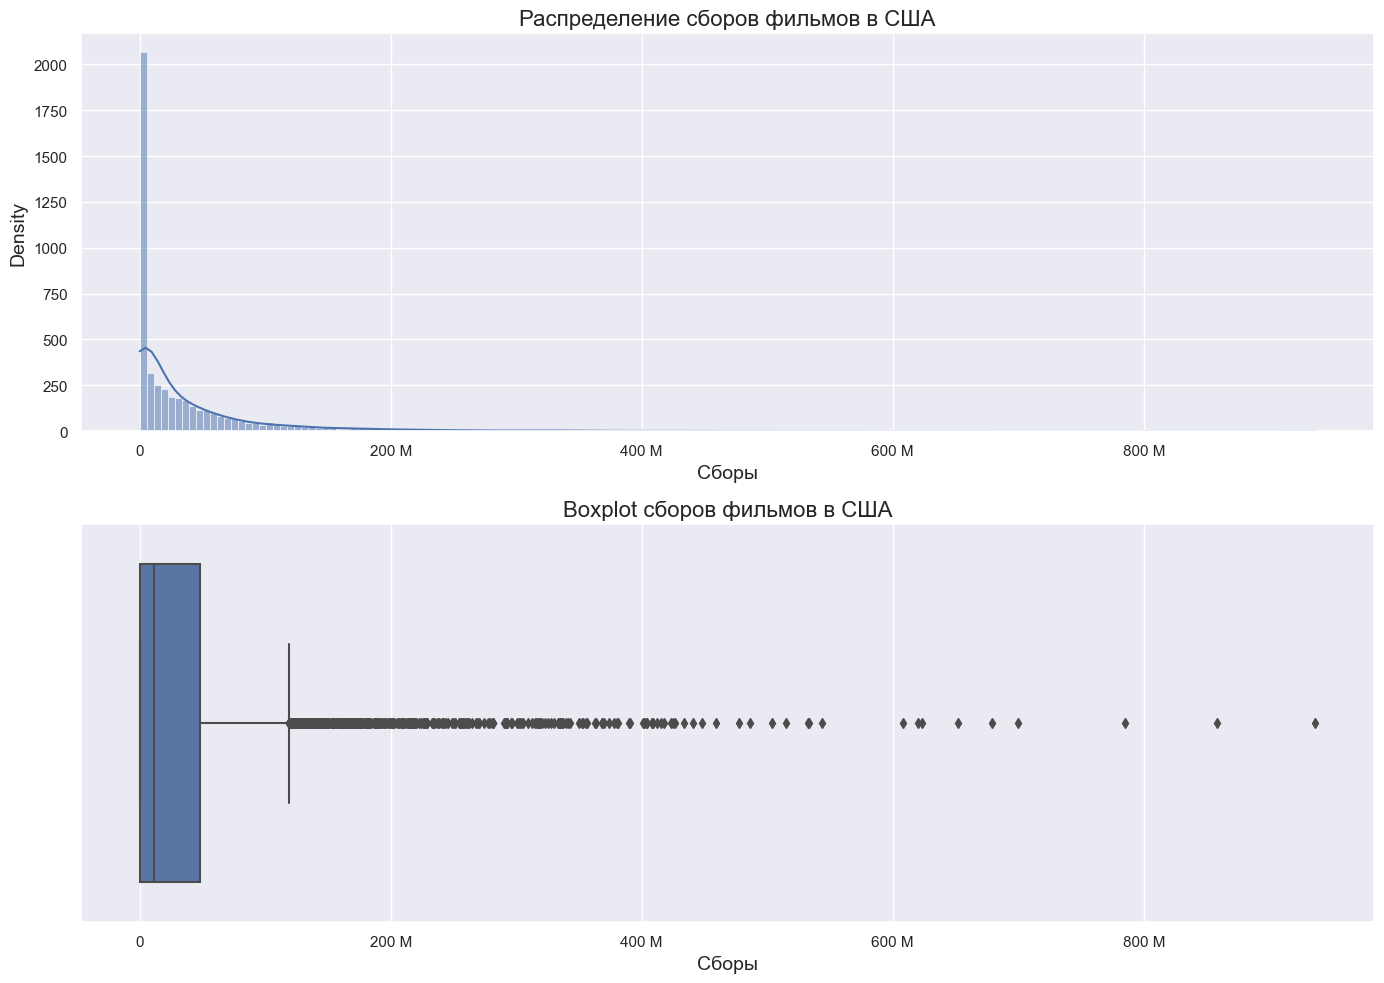

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

sns.histplot(df.fees_usa, ax=axes[0], kde=True)
axes[0].set_title('Распределение сборов фильмов в США', fontsize=16)
axes[0].set_xlabel('Сборы', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)

sns.boxplot(x=df.fees_usa, orient='h', ax=axes[1])
axes[1].set_title('Boxplot сборов фильмов в США', fontsize=16)
axes[1].set_xlabel('Сборы', fontsize=14)

ENG_FORMAT = ticker.EngFormatter()
axes[0].xaxis.set_major_formatter(ENG_FORMAT)
axes[1].xaxis.set_major_formatter(ENG_FORMAT)

xlimits = axes[0].get_xlim()
axes[1].set_xlim(xlimits)

plt.tight_layout()
plt.show()

1. **Диапазон сборов:** Сборы фильмов варьируются от 0 до ~940 миллионов долларов.


2. **Медианные сборы:** Медианное значение сборов составляет ~10 миллионов долларов. Большая часть фильмов имеет сборы в пределах нескольких миллионов долларов
   
   
3. **Выбросы:** 
   - Существует около 500 фильмов, сборы которых превышают верхний предел выбросов. Эти фильмы можно рассматривать как блокбастеры или особо успешные проекты.
   - Отсутствие низких выбросов и наличие многих высоких выбросов указывает на то, что в индустрии кино очень высокий потенциал прибыли для определенных проектов.


4. **Общий вывод:** 

- Целевая переменная имеет длинный правый хвост. Распределение асимметричное. 
   <br>Есть много фильмов, имеющих относительно невысокие сборы, и небольшое количество фильмов с очень высокими сборами.

# Сбор уникальных значений в данных

In [10]:
def save_unique_train_data(data: pd.DataFrame,
                           drop_columns: list,
                           target_column: str,
                           unique_values_path: str) -> None:
    """
    Сохранение словаря с признаками и уникальными значениями
    :param data: датасет
    :param drop_columns: список с признаками для удаления
    :param target_column: целевая переменная
    :param unique_values_path: путь до файла со словарем
    :return: None
    """
    unique_df = data.drop(
        columns=drop_columns + [target_column], axis=1, errors="ignore")
        
    # создаем словарь с уникальными значениями для вывода в UI
    dict_unique = {
        key: data[key].dropna().unique().tolist()
        for key in data.columns
    }
    with open(unique_values_path, 'w', encoding='utf-8') as file:
        json.dump(dict_unique, file, indent=4, ensure_ascii=False)

In [11]:
save_unique_train_data(
            data=df,
            drop_columns=preproc["drop_columns"],
            target_column=preproc["target_column"],
            unique_values_path=preproc["unique_values_path"],
        )

# Гипотеза (сборы и год выпуска + кол-во фильмов)

С течением лет, сборы фильмов в США увеличиваются, также увеличивается количество выпущенных фильмов.

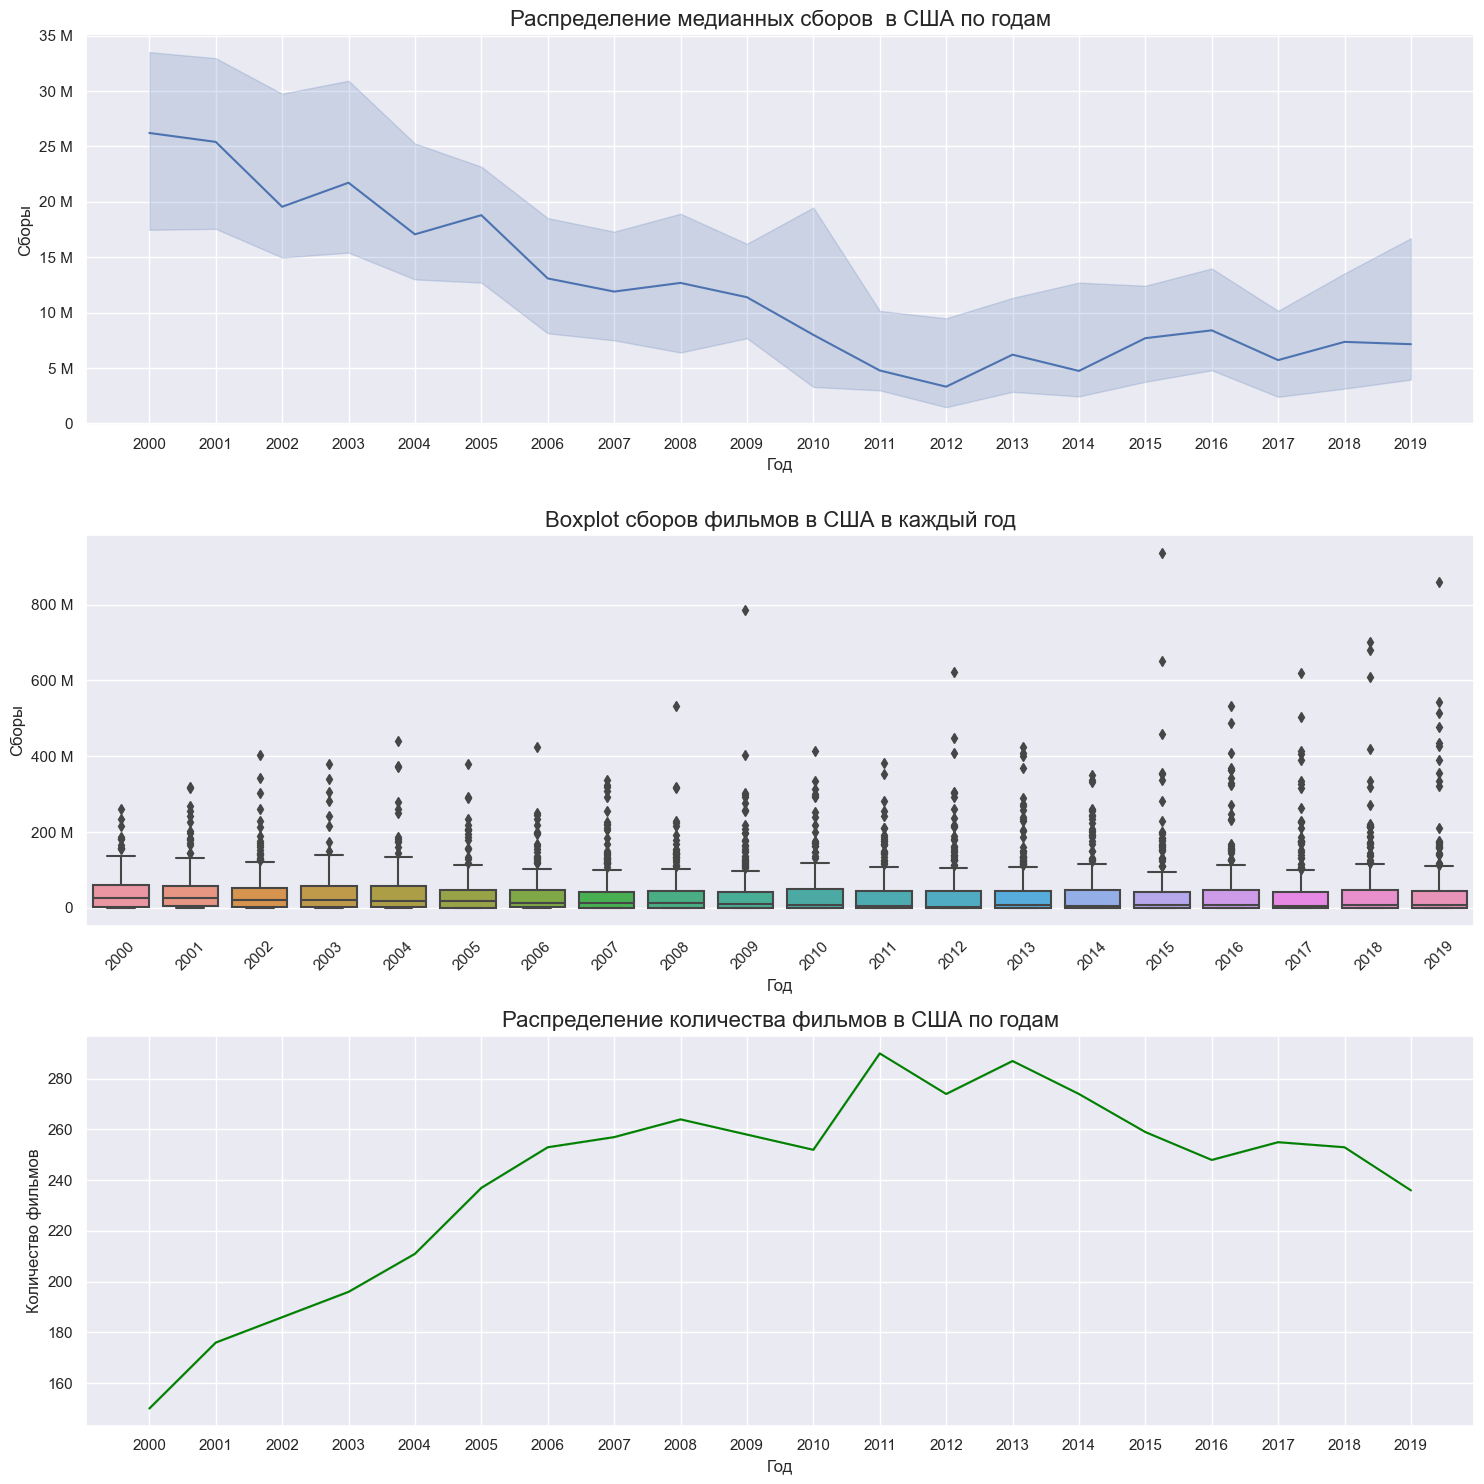

In [12]:
def plot_count_year_fees(df: pd.DataFrame, target_col: str, year_col: str):
    """
    Построение трёх графиков для анализа сборов и количества фильмов по годам.

    :param df: DataFrame.
    :param target_col: Имя колонки с информацей о сборах фильмов.
    :param year_col: Имя колонки, содержащей информацию о годе выхода фильмов.
    :return: None
    """

    fig, axs = plt.subplots(3, 1, figsize=(15, 15))  # 3 графика
    sns.set(font_scale=1.)

    max_year = int(df[year_col].max())
    min_year = int(df[year_col].min())

    sns.lineplot(data=df,
                 x=year_col,
                 y=target_col,
                 ax=axs[0],
                 estimator=np.median)
    axs[0].set_title("Распределение медианных сборов  в США по годам",
                     fontsize=16)
    axs[0].set_ylabel("Сборы")

    sns.boxplot(data=df, x=year_col, y=target_col, showfliers=True, ax=axs[1])
    axs[1].set_title(f"Boxplot сборов фильмов в США в каждый год",
                     fontsize=16)
    axs[1].set_ylabel('Сборы')
    axs[1].tick_params(axis='x', rotation=45)

    df['movie_count'] = df.groupby(year_col).transform('size')
    sns.lineplot(data=df,
                 x=year_col,
                 y='movie_count',
                 ax=axs[2],
                 color='green')
    axs[2].set_title("Распределение количества фильмов в США по годам",
                     fontsize=16)
    axs[2].set_ylabel("Количество фильмов")

    for ax in axs:
        ax.yaxis.set_major_formatter(ENG_FORMAT)
        ax.set_xlabel("Год")

    axs[0].set_xticks(list(range(min_year, max_year + 1, 1)))
    axs[2].set_xticks(list(range(min_year, max_year + 1, 1)))

    plt.tight_layout()
    plt.show()


plot_count_year_fees(df=df,
                     target_col=preproc['target_column'],
                     year_col=preproc['year_column'])

**Выводы**:

**Количество выпущенных фильмов:**
<br>В период с 2000 по 2008 наблюдается общая тенденция к увеличению количества фильмов. Этот тренд может отражать общий рост и динамичность кинопромышленности в начале 21-го века. После 2008 года количество фильмов в каждом году колеблется, не показывая четкой тенденции к росту или уменьшению.

**Медианные сборы:**
С 2000 по 2010 год наблюдается тенденция к уменьшению медианных сборов фильмов на фоне роста их общего количества. Причиной этому может быть большее число фильмов с низкими сборами, что снижает медиану.

**Максимальные сборы:** 
<br>Максимальные сборы фильмов в США имеют тенденцию к увеличению со временем. Это может быть обусловлено инфляцией, ростом кинопроизводства и маркетинга, технологическими инновациями, а также изменениями потребительских предпочтений.

# Гипотеза  (возрастной рейтинг и сборы)

Фильмы, предназначенные для более широкой аудитории (например, 6+, 12+ и 16+), имеют тенденцию привлекать больше зрителей и иметь более высокие сборы по сравнению с фильмами для взрослой аудитории (18+).

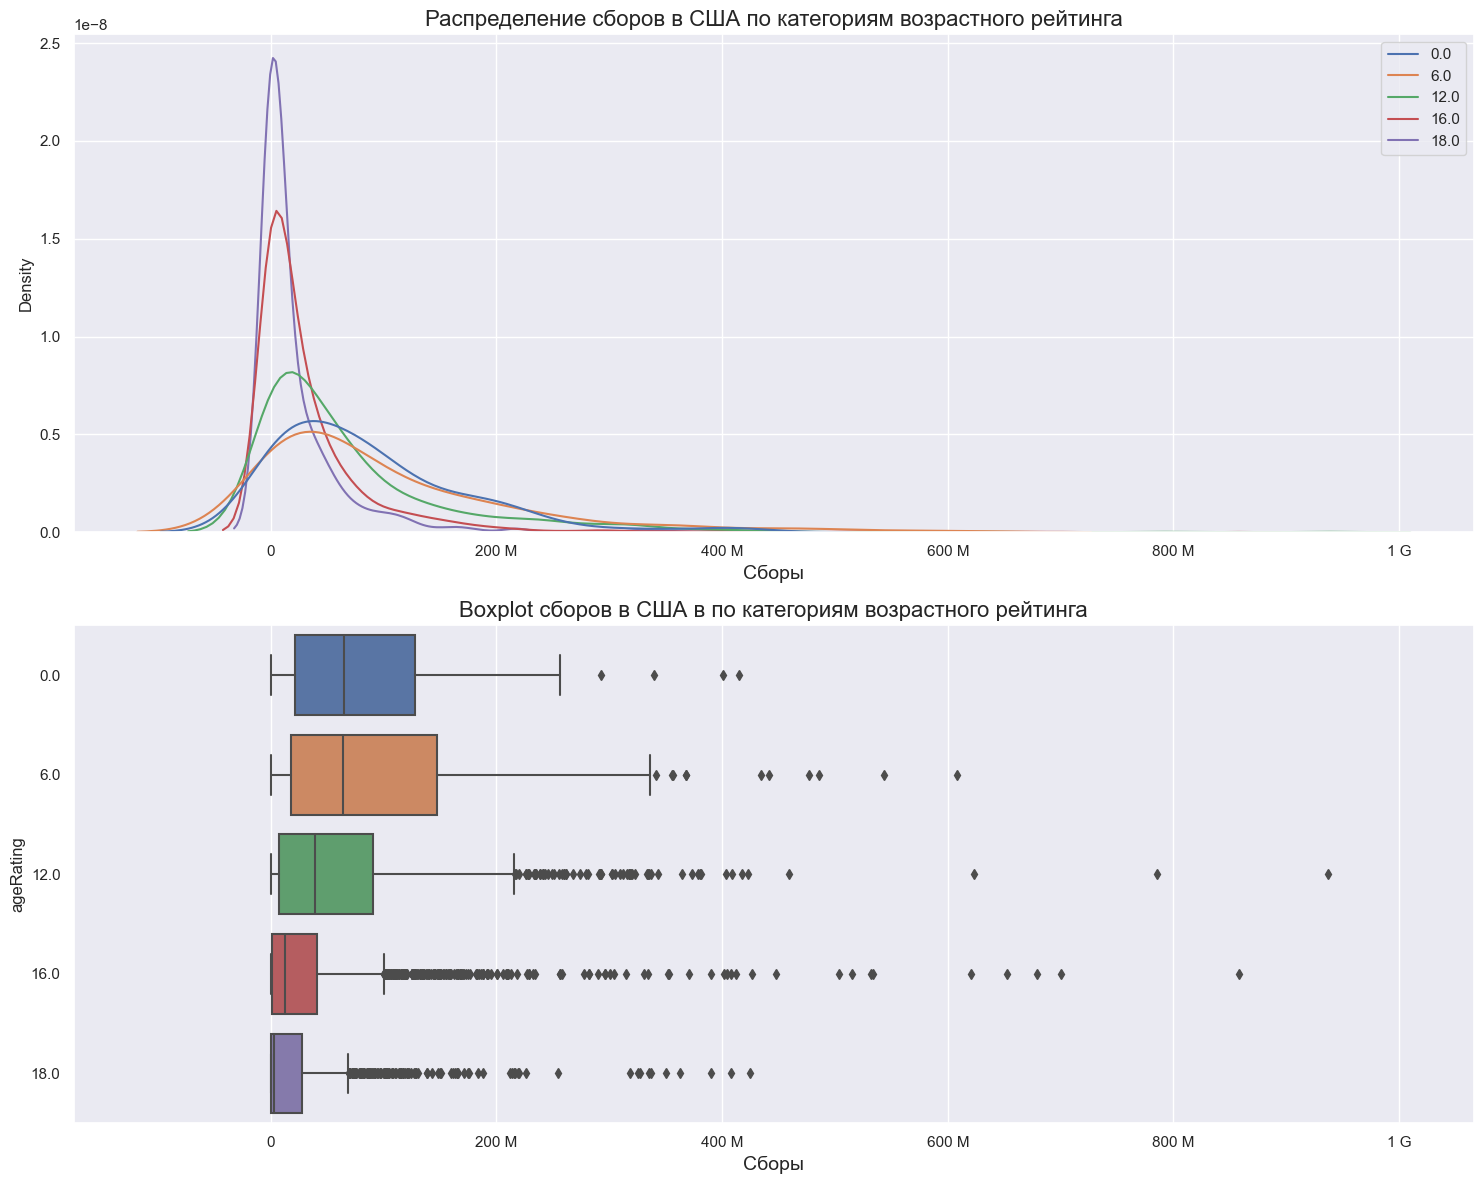

In [18]:
def plot_distributions(df: pd.DataFrame, category_col: str, value_col: str,
                       title_kde: str, title_boxplot: str, xlabel: str) -> None:
    """
    Построение KDE и Boxplot графиков для распределений
    числовых значений по категориям в DataFrame.

    :param df: DataFrame с числовыми и категориальными данными.
    :param category_col: Имя категориальной колонки  для группировки.
    :param value_col: Имя числовой колонки для распределений.
    :param title_kde: Заголовок для KDE-графика.
    :param title_boxplot: Заголовок для боксплота.
    :param xlabel: Подпись оси X для обоих графиков.
    :return: None
    """
        
    # Удаляем пропуски и получаем уникальные значения для категориальной колонки
    unique_categories = df[category_col].dropna().unique()
    unique_categories.sort() 

    # Создаем словарь для данных
    data = {
        str(category): df[df[category_col] == category][value_col]
        for category in unique_categories
    }

    # Построение графиков
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

    # KDE plot
    sns.kdeplot(data=data, common_norm=False, ax=axes[0])
    # Boxplot
    sns.boxplot(data=df,
                y=category_col,
                x=value_col,
                orient='h',
                showfliers=True,
                ax=axes[1])

    axes[0].set_title(title_kde, fontsize=16)
    axes[1].set_title(title_boxplot, fontsize=16)

    axes[1].xaxis.set_major_formatter(ENG_FORMAT)
    axes[0].xaxis.set_major_formatter(ENG_FORMAT)

    axes[0].set_xlabel(xlabel, fontsize=14)
    axes[1].set_xlabel(xlabel, fontsize=14)

    # Установка одинаковых пределов для оси X для обоих графиков
    xlimits = axes[0].get_xlim()
    axes[1].set_xlim(xlimits)

    plt.tight_layout()

    plt.show()


plot_distributions(
    df=df,
    category_col='ageRating',
    value_col=preproc['target_column'],
    title_kde='Распределение сборов в США по категориям возрастного рейтинга',
    title_boxplot='Boxplot сборов в США в по категориям возрастного рейтинга',
    xlabel='Сборы')

**Выводы:**

1. **Максимальные сборы**: 
<br>Фильмы с рейтингом 6+ и 12+ имеют высшие максимальные сборы. Фильмы с такими рейтингами имеют потенциал стать блокбастерами.


2. **Медианные значения**: 
<br>Медианные сборы для фильмов с рейтингами 6+, 12+ и 16+ примерно сопоставимы и значительно выше, чем для 18+.


3. **Выбросы**: 
Фильмы с рейтингами 12+, 16+ и 6+ имеют значительное количество высоких выбросов в сборах. 
Значит некоторые фильмы в этих категориях имели огромный успех.


4. **Общие наблюдения**:
<br>Фильмы с рейтингом 18+ склонны иметь менее стабильные сборы и меньший потенциал для высоких доходов по сравнению с фильмами других рейтингов, хотя исключения, конечно, существуют.

# Гипотеза (сборы и тип картины)

Мультфильмы в среднем собирают больше денег в США, чем кинофильмы.

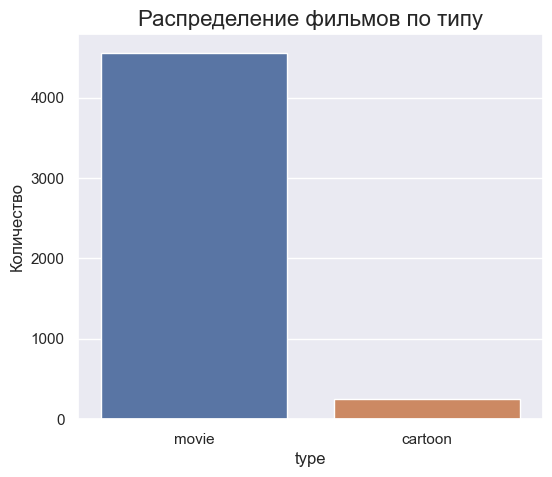

In [19]:
def plot_category_distribution(df: pd.DataFrame,
                               category_col: str,
                               title: str = None) -> None:
    """
    Построение столбчатой диаграммы распределения значений 
    в указанной категориальной колонке DataFrame.

    :param df: DataFrame с категориальными данными.
    :param category_col: Имя колонки для построения диаграммы распределения.
    :param title: Заголовок для графика.
    :return: None
    """

    # Получаем подсчеты количества для категории
    category_counts = df[category_col].value_counts().reset_index()
    category_counts.columns = [category_col, 'Количество']

    fig = plt.figure(figsize=(6, 5))
    sns.barplot(x=category_col,
                y='Количество',
                data=category_counts,
                order=category_counts[category_col])

    # Настройка заголовка
    if title is None:
        title = f'Распределение по категории {category_col}'
    plt.title(title, fontsize=16)
    plt.show()


plot_category_distribution(df, 'type', title='Распределение фильмов по типу')

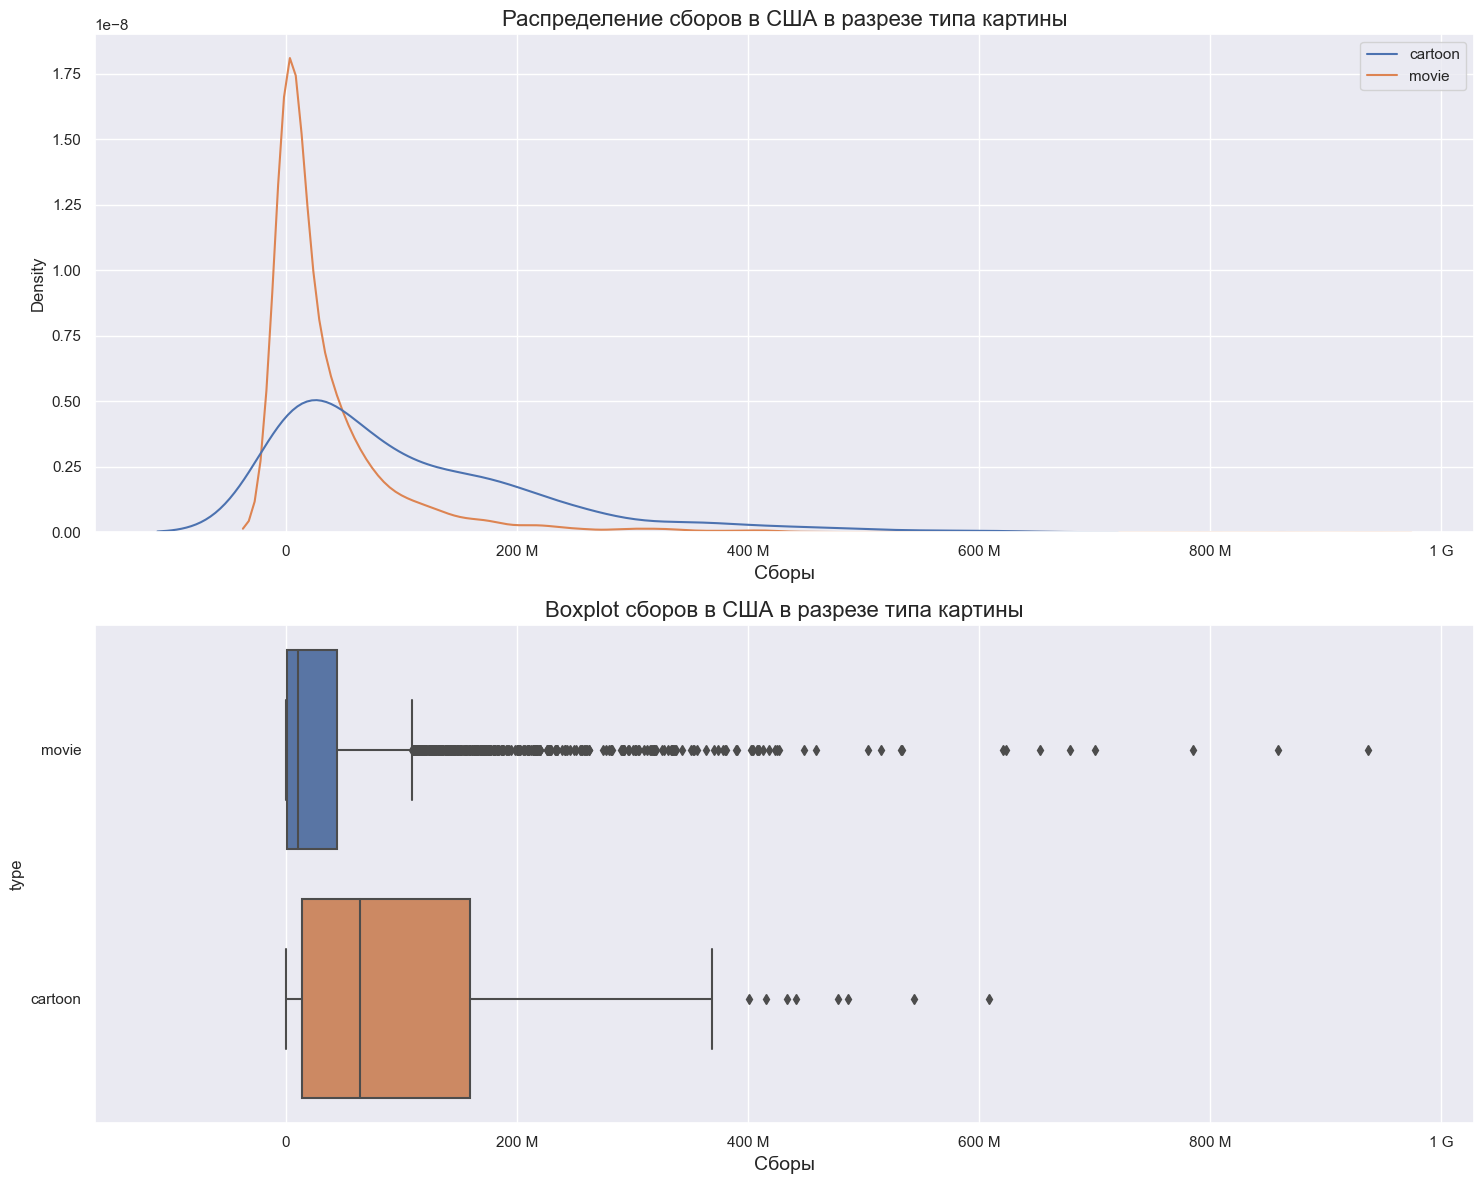

In [48]:
plot_distributions(
                df=df,
                category_col='type',
                value_col=preproc['target_column'],
                title_kde='Распределение сборов в США в разрезе типа картины',
                title_boxplot='Boxplot сборов в США в разрезе типа картины',
                xlabel='Сборы'
            )

**Выводы:**

 - Большая часть данных относится к фильмам (не мультфильмам).
 
 
 - Медианный сбор мультфильмов составляет примерно 60 млн долларов, что значительно выше, чем для кинофильмов (9 млн долларов). Также есть мультфильмы с выдающимися сборами, превышающими 400 млн долларов.
 
- Несмотря на то что мультфильмов гораздо меньше, их медиана сборов выше. 
  Это может указывать на то, что мультфильмы в целом более прибыльны, 
  чем кинофильмы, или имеют большую аудиторию в США.

# Гипотеза (жанры и сборы)

Фильмы с популярными жанрами собирают больше денег.

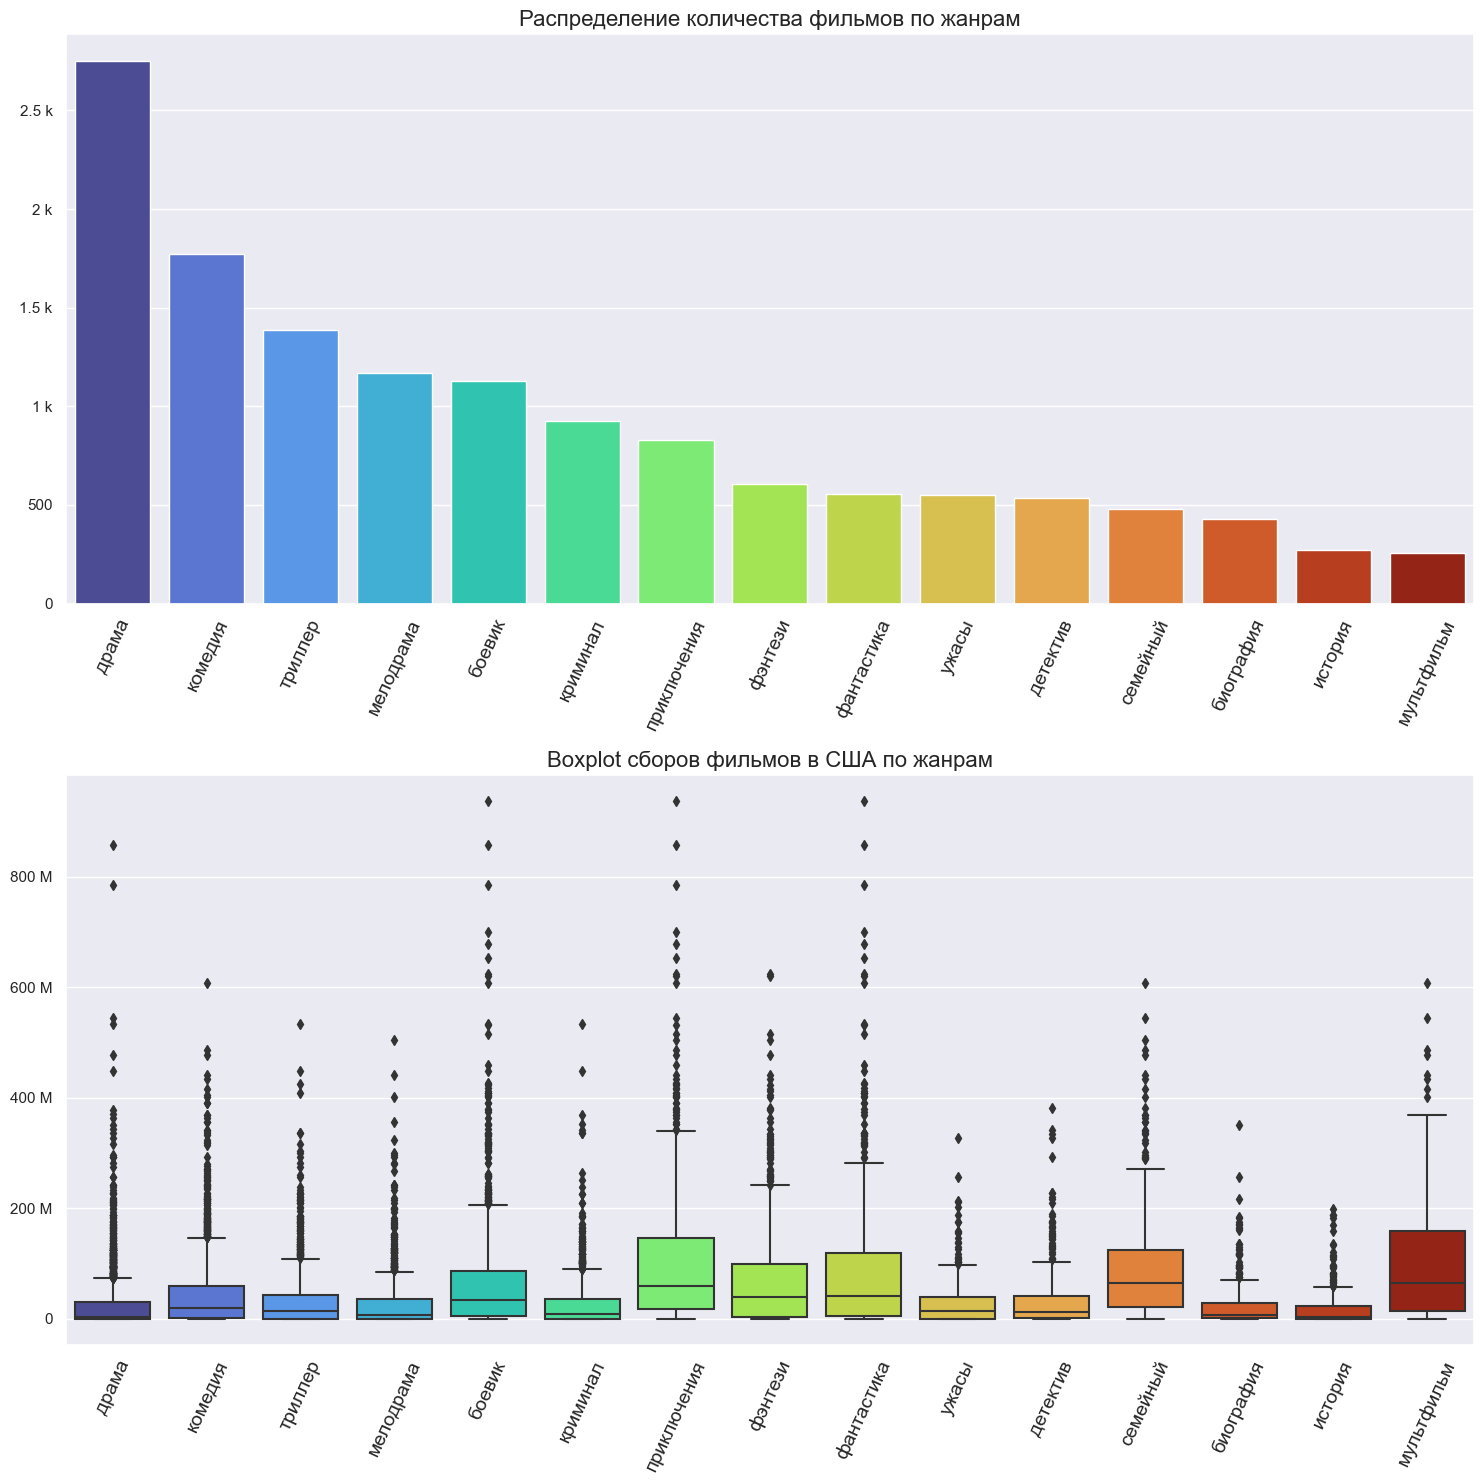

In [37]:
def parse_series_to_lists(series: pd.Series) -> pd.Series:
    """
    Преобразование элементов Series в списки
    :param series: объект Series для преобразования
    :return: обновленный объект Series с типом list
    """
    # Заполняем отсутствующие значения пустыми списками
    series = series.fillna("[]")
    # Преобразуем каждый элемент в список
    series = series.apply(lambda x: x
                          if isinstance(x, list) else ast.literal_eval(x))
    return series


def make_dummies(df: pd.DataFrame,
                 col: str,
                 top_dummies_num: int = 15) -> pd.DataFrame:
    """
    Создает бинаризованные колонки для указанного признака в dataframe
    :param df: датасет
    :param col: колонка для бинаризации
    :param top_dummies_num: топ количество самых часто встречающихся колонок
    :return: датасет с бинаризованными колонками
    """
    df[col] = parse_series_to_lists(df[dummies_col])

    dummies = df[col].str.join("|").str.get_dummies(sep="|")
    sorted_counts = dummies.sum().sort_values(ascending=False)
    top_cols = sorted_counts.iloc[:top_dummies_num].index
    return dummies[top_cols]


def plot_fees_dummies(
    df: pd.DataFrame,
    target_col: str,
    dummies_col: str,
    title_barplot: str,
    title_boxplot: str,
) -> None:
    """
    Строит столбчатую диаграмму и boxplot, используя данные
    целевой переменной и категории
    :param df: датасет
    :param target_col: имя колонки, содержащей целевую переменную
    :param dummies_col: имя колонки для бинаризации
    :param title_barplot: заголовок для столбчатой диаграммы
    :param title_boxplot: заголовок для boxplot
    :return: None
    """
    dummies = make_dummies(df, dummies_col)
    counts = dummies.sum()

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

    sns.barplot(x=counts.index, y=counts.values, palette='turbo', ax=axes[0])
    axes[0].set_title(title_barplot, fontsize=16)

    # Временный DataFrame для построения графиков
    df_temp = pd.concat([df[[target_col]], dummies], axis=1)
    data = {}
    for col in dummies.columns:
        data[col] = df_temp[df_temp[col] == 1][target_col]

    sns.boxplot(data=pd.DataFrame(data), palette="turbo", ax=axes[1])
    axes[1].set_title(title_boxplot, fontsize=16)

    # Настройка формата осей
    for ax in axes:
        ax.yaxis.set_major_formatter(ENG_FORMAT)
        ax.set_xticklabels(dummies.columns, rotation=90, fontsize=14)
        ax.tick_params(axis="x", rotation=65)

    plt.tight_layout()


plot_fees_dummies(df, 'fees_usa', 'genres',
                  'Распределение количества фильмов по жанрам',
                  'Boxplot сборов фильмов в США по жанрам')

- **Сборы по Жанрам:**
  - **Драма:** Популярный жанр с средними сборами и несколькими кассовыми хитами.
  - **Комедия:** Аналогично драме, второй по популярности, с некоторыми высокими выбросами в сборах.
  - **Приключения:** Меньшая популярность, но более высокие средние сборы.
  - **Фантастика и мультфильмы:** Не самые популярные, но часто с высокими сборами.


- **Выбросы:** Показывают, что хотя большинство фильмов в определенных жанрах может не быть кассовыми хитами, исключения бывают.

**Общий вывод:** 

Успех фильма в кассовых сборах не всегда коррелирует с популярностью его жанра. Менее популярные жанры могут иметь высокие средние сборы, тогда как более популярные жанры часто имеют выбросы, становясь кассовыми хитами, несмотря на низкие медианные сборы.